In [8]:
import sys
import os
import numpy as np
from pathlib import Path

from dotenv import load_dotenv
load_dotenv()
# Add the project root directory to Python path
project_root = str(Path(os.getcwd()).parent)
if project_root not in sys.path:
    sys.path.append(project_root)
import pandas as pd
import matplotlib.pyplot as plt

from utils.plots import EDAPlots
from utils.eia_api import EIADataPuller
from utils.custom_types import StorageRegion, FuelType, EIAConsumptionType

# Program/Anaysis Constants

In [9]:
ANALYSIS_REGION = StorageRegion.EAST
data_puller = EIADataPuller(ANALYSIS_REGION)

# EIA Natural Gas Storage Numbers

In [10]:
df = data_puller.get_storage_data()

print(f"\nDtypes: {df.dtypes}")
df

{'response': {'total': '345', 'dateFormat': 'YYYY-MM-DD', 'frequency': 'weekly', 'data': [{'period': '2019-01-18', 'duoarea': 'R31', 'area-name': 'NA', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'SWO', 'process-name': 'Underground Storage - Working Gas', 'series': 'NW2_EPG0_SWO_R31_BCF', 'series-description': 'Weekly East Region Natural Gas Working Underground Storage (Billion Cubic Feet)', 'value': '566', 'units': 'BCF'}, {'period': '2019-02-08', 'duoarea': 'R31', 'area-name': 'NA', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'SWO', 'process-name': 'Underground Storage - Working Gas', 'series': 'NW2_EPG0_SWO_R31_BCF', 'series-description': 'Weekly East Region Natural Gas Working Underground Storage (Billion Cubic Feet)', 'value': '444', 'units': 'BCF'}, {'period': '2019-05-03', 'duoarea': 'R31', 'area-name': 'NA', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'SWO', 'process-name': 'Underground Storage - Working Gas', 'series': 'NW2_EP

,EAST_NG_Storage_BCF,Week,Year
0,677,31,2025
1,656,30,2025
2,651,29,2025
3,634,28,2025
4,628,27,2025
...,...,...,...
340,468,4,2019
341,527,3,2019
342,566,2,2019
343,620,1,2019


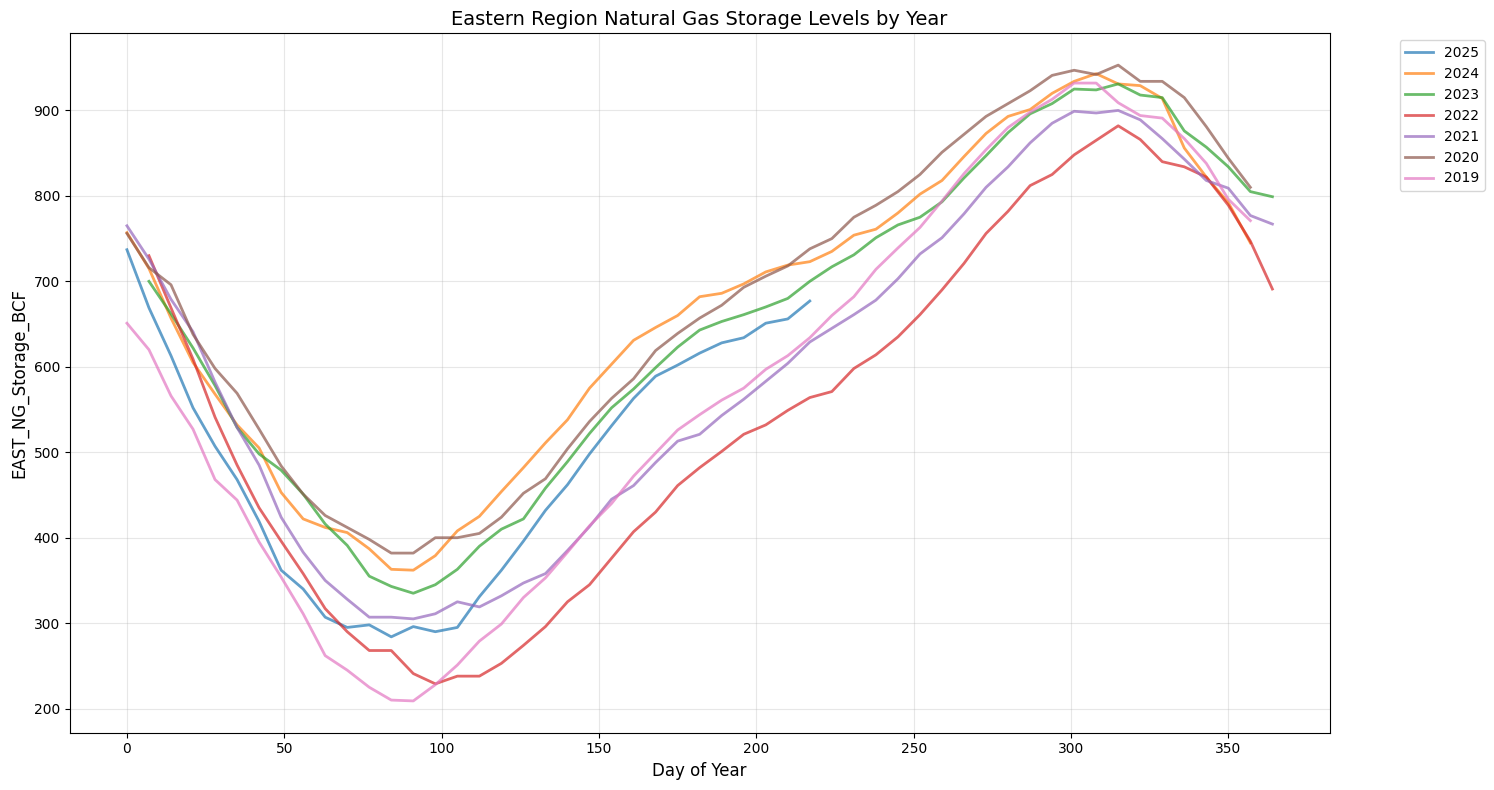

In [ ]:
ng_plot_df = df.assign(DayOfYear=lambda x: x['Week'] * 7)
EDAPlots.generate_year_plot(ng_plot_df, f'{ANALYSIS_REGION.name}_NG_Storage_BCF', f"{ANALYSIS_REGION.name} Regional Natural Gas Storage Levels by Year")

# Power Generation

Pros: Power Generation from burnt fuel is very granual (daily)  
Cons: Data only extends back to 2019, we will simply graph this data to determine if any other series can be used as a replacement to allow us to use years before 2019

In [12]:
power_gen_df = data_puller.get_power_gen_data(FuelType.NATURAL_GAS)
print(f"\nDtypes: {power_gen_df.dtypes}")
power_gen_df

{'warnings': [{'warning': 'incomplete return', 'description': 'The API can only return 5000 rows in JSON format.  Please consider constraining your request with facet, start, or end, or using offset to paginate results.'}], 'response': {'total': '9663', 'dateFormat': 'YYYY-MM-DD', 'frequency': 'daily', 'data': [{'period': '2025-08-13', 'respondent': 'CAR', 'respondent-name': 'Carolinas', 'fueltype': 'NG', 'type-name': 'Natural Gas', 'timezone': 'Eastern', 'timezone-description': 'Eastern', 'value': '210880', 'value-units': 'megawatthours'}, {'period': '2025-08-13', 'respondent': 'MIDA', 'respondent-name': 'Mid-Atlantic', 'fueltype': 'NG', 'type-name': 'Natural Gas', 'timezone': 'Eastern', 'timezone-description': 'Eastern', 'value': '1425018', 'value-units': 'megawatthours'}, {'period': '2025-08-13', 'respondent': 'NE', 'respondent-name': 'New England', 'fueltype': 'NG', 'type-name': 'Natural Gas', 'timezone': 'Eastern', 'timezone-description': 'Eastern', 'value': '246240', 'value-units

,Week,Year,EAST_NG_Power_Gen_MWh
0,0,2019,9.004496e+05
1,0,2020,1.050378e+06
2,0,2021,1.181554e+06
3,0,2022,9.600410e+05
4,0,2024,1.585946e+06
...,...,...,...
346,52,2021,1.201993e+06
347,52,2022,1.214021e+06
348,52,2023,1.318246e+06
349,52,2024,1.221313e+06


In [ ]:
power_gen_plot_df = power_gen_df.assign(DayOfYear=lambda x: x['Week'] * 7)
EDAPlots.generate_year_plot(power_gen_plot_df, f"{ANALYSIS_REGION.name}_NG_Power_Gen_MWh", f"{ANALYSIS_REGION.name} Natural Gas Power Generation by Week")

ValueError: Columns ['Region_NG_Power_Gen_MWh'] are required for the plot

# NG Usage Data

While there are many options for natural gas usage (all of which we will use for our model), we will take a look at the Elecricity consumption type to see if we can approximate the pattern provided by the EIA power burn dataset (peak in summer months, slight rise in Winter)

In [ ]:
usage_type = EIAConsumptionType.ELECTRICITY
elecricity_usage_df = data_puller.get_ng_usage_data(usage_type)
elecricity_usage_df

{'response': {'total': '735', 'dateFormat': 'YYYY-MM', 'frequency': 'monthly', 'data': [{'period': '2005-05', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VEU', 'process-name': 'Electric Power Consumption', 'series': 'N3045NE2', 'series-description': 'Nebraska Natural Gas Deliveries to Electric Power Consumers (MMcf)', 'value': '496', 'units': 'MMCF'}, {'period': '2005-08', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VEU', 'process-name': 'Electric Power Consumption', 'series': 'N3045NE2', 'series-description': 'Nebraska Natural Gas Deliveries to Electric Power Consumers (MMcf)', 'value': '1316', 'units': 'MMCF'}, {'period': '2006-01', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VEU', 'process-name': 'Electric Power Consumption', 'series': 'N3045NE2', 'series-description': 'Nebraska Natural Gas Deliveries to Elec

,period,duoarea,area-name,product,product-name,process,process-name,series,series-description,value,units
0,2005-05,SNE,USA-NE,EPG0,Natural Gas,VEU,Electric Power Consumption,N3045NE2,Nebraska Natural Gas Deliveries to Electric Po...,496,MMCF
1,2005-08,SNE,USA-NE,EPG0,Natural Gas,VEU,Electric Power Consumption,N3045NE2,Nebraska Natural Gas Deliveries to Electric Po...,1316,MMCF
2,2006-01,SNE,USA-NE,EPG0,Natural Gas,VEU,Electric Power Consumption,N3045NE2,Nebraska Natural Gas Deliveries to Electric Po...,123,MMCF
3,2007-07,SNE,USA-NE,EPG0,Natural Gas,VEU,Electric Power Consumption,N3045NE2,Nebraska Natural Gas Deliveries to Electric Po...,2503,MMCF
4,2008-09,SNE,USA-NE,EPG0,Natural Gas,VEU,Electric Power Consumption,N3045NE2,Nebraska Natural Gas Deliveries to Electric Po...,288,MMCF
...,...,...,...,...,...,...,...,...,...,...,...
730,2018-11,SFL,FLORIDA,EPG0,Natural Gas,VEU,Electric Power Consumption,N3045FL2,Florida Natural Gas Deliveries to Electric Pow...,94725,MMCF
731,2019-07,SFL,FLORIDA,EPG0,Natural Gas,VEU,Electric Power Consumption,N3045FL2,Florida Natural Gas Deliveries to Electric Pow...,131563,MMCF
732,2024-05,SFL,FLORIDA,EPG0,Natural Gas,VEU,Electric Power Consumption,N3045FL2,Florida Natural Gas Deliveries to Electric Pow...,137267,MMCF
733,2024-12,SFL,FLORIDA,EPG0,Natural Gas,VEU,Electric Power Consumption,N3045FL2,Florida Natural Gas Deliveries to Electric Pow...,96984,MMCF


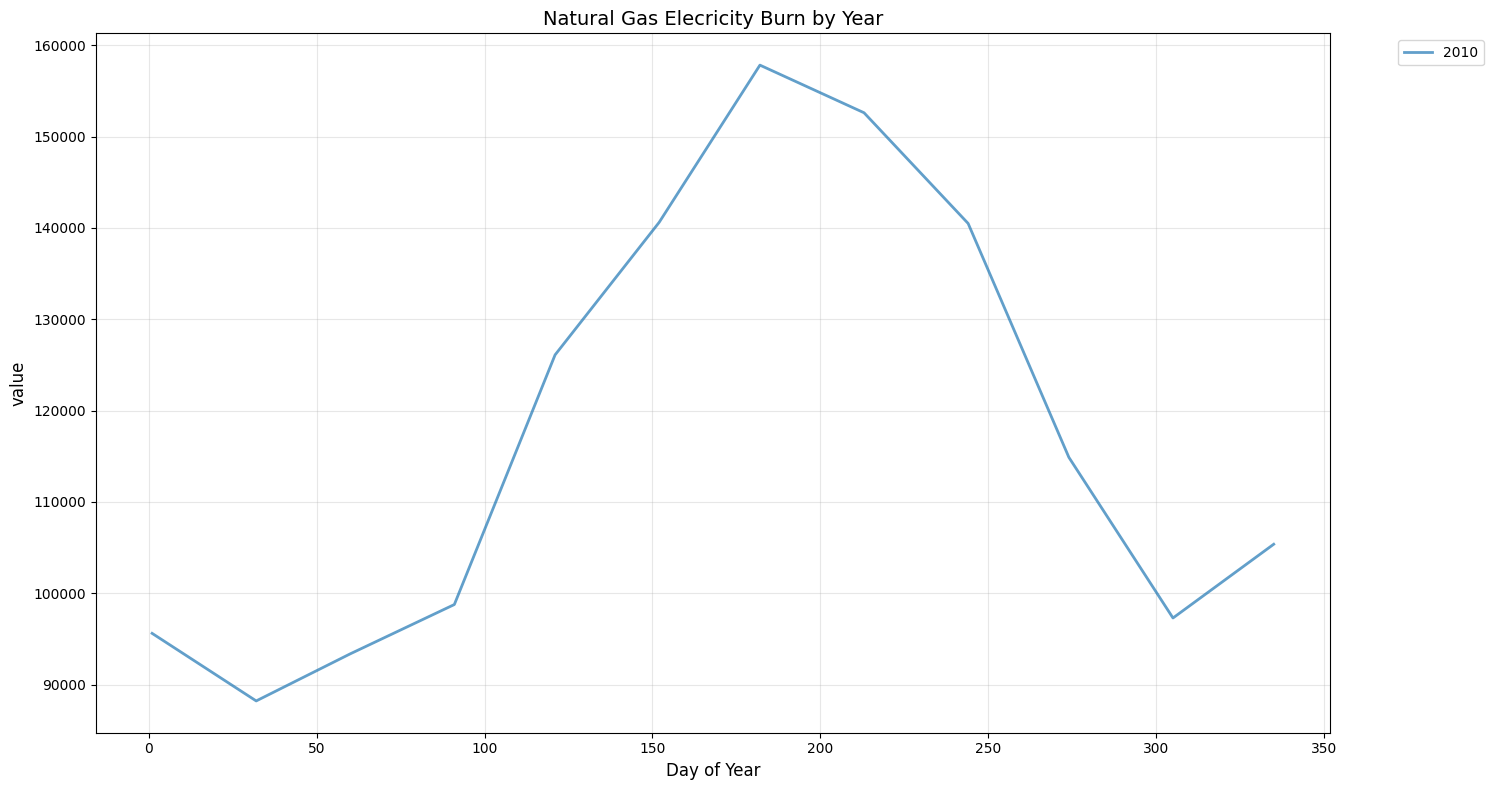

In [ ]:
elecricity_plot_df = elecricity_usage_df.assign(DayOfYear=lambda x: x["period"].dt.dayofyear)
EDAPlots.generate_year_plot(elecricity_plot_df, "value", "Natural Gas Elecricity Burn by Year")

In [ ]:

# Extend final timedelta by 4 weeks to entirity of last month isn't cut off in weekly time series
weekly_index = pd.date_range(elecricity_usage_df['period'].min(), elecricity_usage_df['period'].max() + pd.Timedelta(weeks=4), freq='W', inclusive='both')

# Calculate scaling factor (1 / number of weeks in month)
weekly_df = (pd.DataFrame(weekly_index,columns=['period'])
    .sort_values(by=["period"])
    .assign(Year=lambda x: x['period'].dt.year,
            Month=lambda x: x['period'].dt.month,
            Week=lambda x: x['period'].dt.strftime("%U").astype(int))
)

weekly_df['is_middle_week'] = (weekly_df
    .groupby(weekly_df['period'].dt.to_period('M'), group_keys=False)
    .apply(lambda g: g['period'] == min(g['period'], key=lambda d: abs(d - (d.replace(day=15)))))
)

weekly_df =(pd.merge(weekly_df, ls.drop(columns=["period"]), on=["Year", "Month"], how="left")
    .assign(value=lambda x: x['value'].where(x['is_middle_week'], np.nan).interpolate('linear', limit_direction='both') / 4)
    .drop(columns=["is_middle_week"])
)
weekly_df

,period,Year,Month,Week,value
0,2005-01-02,2005,1,1,15791.5
1,2005-01-09,2005,1,2,15791.5
2,2005-01-16,2005,1,3,15791.5
3,2005-01-23,2005,1,4,15171.5
4,2005-01-30,2005,1,5,14551.5
...,...,...,...,...,...
1060,2025-04-27,2025,4,17,36845.1
1061,2025-05-04,2025,5,18,38189.9
1062,2025-05-11,2025,5,19,39534.7
1063,2025-05-18,2025,5,20,40879.5


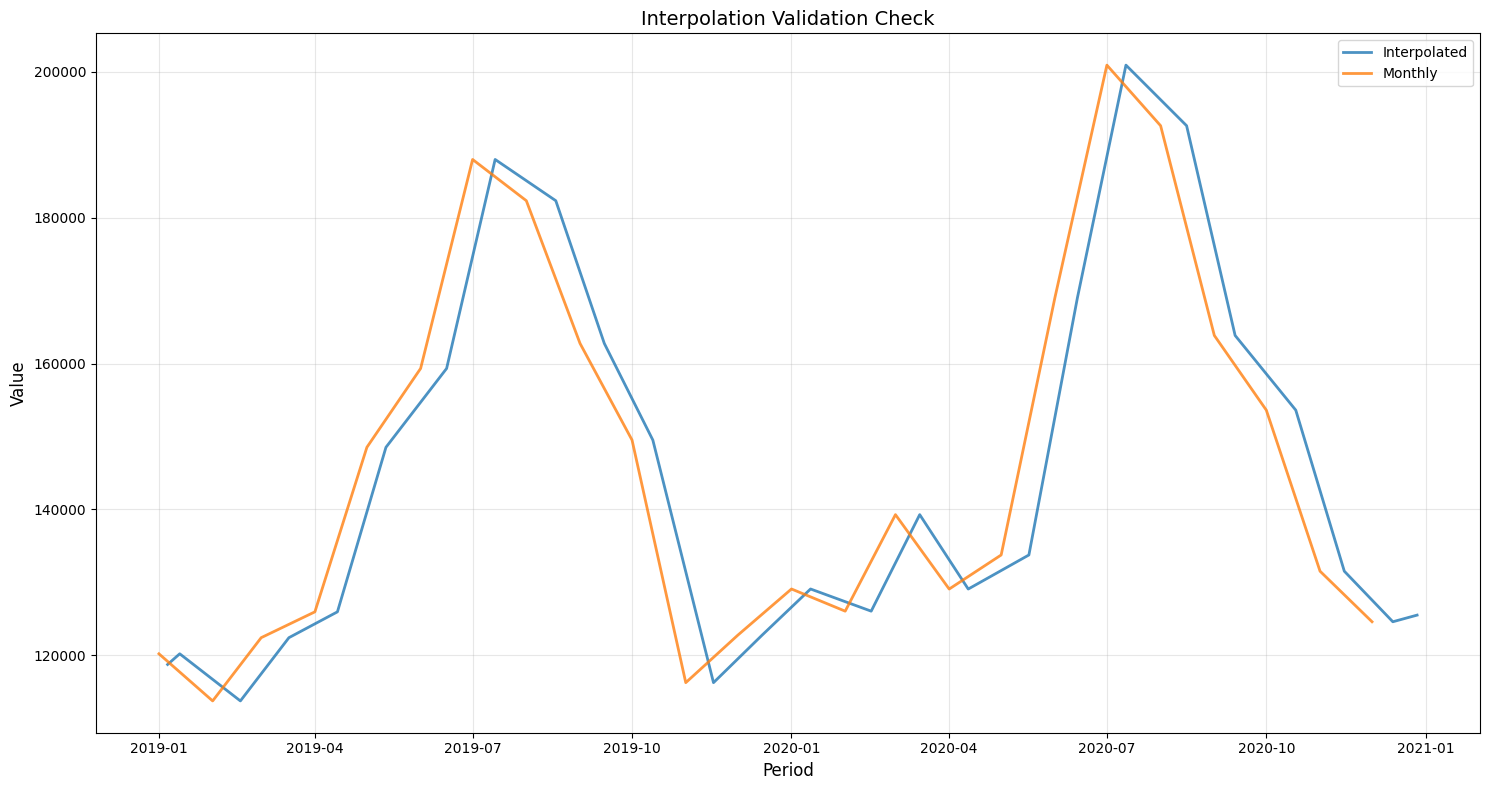

In [ ]:
check_year = 2019
EDAPlots.plot_dual_time_series_separate_dfs(
    title="Interpolation Validation Check", 
    df1=weekly_df[(weekly_df['Year'] == check_year) | (weekly_df['Year'] == check_year + 1)].assign(value=lambda x: x['value'] * 4), 
    series1_col="value", 
    df2=elecricity_usage_df[(elecricity_usage_df['Year'] == check_year) | (elecricity_usage_df['Year'] == check_year + 1)], 
    series2_col="value", 
    series1_label="Interpolated", 
    series2_label="Monthly"
)

The Interpolated graph is shifted to the right of the monthly series graph. Since we are centering the monthly time series on the middle week of every month, this is expected.